In [1]:
%run ../scripts/notebook_settings_lean.py
from scipy import stats
from horizonplot import horizonplot
from chromwindow import window
import zarr
import allel
pd.options.display.float_format = '{:10,.3g}'.format #

Loading metadata

In [2]:
zarr_chrX_dir = "/home/eriks/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/chrX"
#Opening the zarr data
callset_f = zarr.open_group(zarr_chrX_dir, mode="r")
gt_f = allel.GenotypeArray(callset_f["calldata/GT"])
pos_f = callset_f["variants/POS"][:]

zarr_all_chrX_dir = "/home/eriks/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/all_chrX"
#Opening the zarr data
callset_all_chrX = zarr.open_group(zarr_all_chrX_dir, mode="r")
gt_all_chrX = allel.GenotypeArray(callset_all_chrX["calldata/GT"])
pos_all_chrX = callset_all_chrX["variants/POS"][:]

zarr_dipmale_chrX = "/home/eriks/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/dipmale_chrX"
#Opening the zarr data
callset_dipmale_chrX = zarr.open_group(zarr_dipmale_chrX, mode="r")

In [3]:
hap_starter = pd.read_csv("../data/haploid_metadata.txt", sep =" ")
meta_data_samples_sci = pd.read_csv("../data/Papio_metadata_with_clustering_sci.txt", sep =" ")
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")

#Generate a mapping between metadata and callset - repeat for chrX females to be sure of no errors.
ID_to_callset = dict(zip(callset_all_chrX["samples"][:], range(len(callset_all_chrX["samples"][:]))))
hap_meta_data_samples = hap_starter.loc[hap_starter.PGDP_ID.isin(callset_all_chrX["samples"][:])].copy()
hap_meta_data_samples["callset_index"] = hap_meta_data_samples.PGDP_ID.map(ID_to_callset)

ID_to_callset_f = dict(zip(callset_f["samples"][:], range(len(callset_f["samples"][:]))))
meta_data_samples_f = meta_data_samples_sci.loc[meta_data_samples_sci.PGDP_ID.isin(callset_f["samples"][:])].copy()
meta_data_samples_f["callset_index"] = meta_data_samples_f.PGDP_ID.map(ID_to_callset_f)

ID_to_callset_dip = dict(zip(callset_dipmale_chrX["samples"][:], range(len(callset_dipmale_chrX["samples"][:]))))
meta_data_samples_dip = meta_data_samples_sci.loc[meta_data_samples_sci.PGDP_ID.isin(callset_dipmale_chrX["samples"][:])].copy()
meta_data_samples_dip["callset_index"] = meta_data_samples_dip.PGDP_ID.map(ID_to_callset_dip)

In [4]:
c_r_g_df = pd.read_csv("../steps/rfmix_stats_df/call_recomb_genes.txt")

In [5]:
rfmix_path = "/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/tanzania_focus/"
df_l = []
chroms = ["chr{}".format(x) for x in (range(1, 21))]+["all_chrX", "female_chrX"]
for c in chroms:
    read_file = rfmix_path + "{}.windows.txt".format(c)
    df = pd.read_csv(read_file, sep="\t")
    if c == "all_chrX":
        df["chrom"] = "chrX"
    df_l.append(df)
window_df_tanz = pd.concat(df_l)
mean_window_df_tanz = window_df_tanz.groupby(["chrom", "individual", "start", "end"]).mean().reset_index().merge(c_r_g_df, on=["chrom", "start"])
tanz_olives = meta_data_samples_sci.loc[meta_data_samples_sci.C_origin == "Anubis, Tanzania"].PGDP_ID
mean_window_df_tanz_olive = mean_window_df_tanz.loc[mean_window_df_tanz.individual.isin(tanz_olives)]

rfmix_path = "/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/eth_olive_focus/"
df_l = []
chroms = ["chr{}".format(x) for x in (range(1, 21))]+["all_chrX", "female_chrX"]
for c in chroms:
    read_file = rfmix_path + "{}.windows.txt".format(c)
    df = pd.read_csv(read_file, sep="\t")
    if c == "all_chrX":
        df["chrom"] = "chrX"
    df_l.append(df)
window_df_eth = pd.concat(df_l)
mean_window_df_eth = window_df_eth.groupby(["chrom", "individual", "start", "end"]).mean().reset_index().merge(c_r_g_df, on=["chrom", "start"])

In [6]:
mean_window_df_tanz = mean_window_df_tanz.loc[mean_window_df_tanz.callable_frac > 0.75]
mean_window_df_eth = mean_window_df_eth.loc[mean_window_df_eth.callable_frac > 0.75]

Autosome and chrX statistics for admixture proportion.

In [7]:
origins_interest = ['Arusha, Tanzania',
       'Gombe, Tanzania', 'Lake Manyara, Tanzania',
       'Mikumi, Tanzania', 'Ngorongoro, Tanzania', 'Ruaha, Tanzania',
       'Selous, Tanzania', 'Serengeti, Tanzania', 'Tarangire, Tanzania',
       'Udzungwa, Tanzania', "Gog Woreda, Gambella region, Ethiopia"]

In [8]:
#Autosome average and chrX workflow
chrom_l, o_l, mean_l = [], [], []
for o in origins_interest:
    o_IDs = meta_data_samples_sci.loc[meta_data_samples_sci.Origin == o].PGDP_ID
    o_df = mean_window_df_tanz.loc[(mean_window_df_tanz.individual.isin(o_IDs)) &
                              (~mean_window_df_tanz.chrom.isin(["chrX", "female_chrX"]))]
    if o == "Gog Woreda, Gambella region, Ethiopia":
        o_l.append("Gog Woreda, Ethiopia")
    else:
        o_l.append(o)
    chrom_l.append("autosome"), mean_l.append(o_df.north_sum.mean()/1000)
    o_df = mean_window_df_tanz.loc[(mean_window_df_tanz.individual.isin(o_IDs)) &
                              (mean_window_df_tanz.chrom.isin(["chrX"]))]
    male_IDs = meta_data_samples_sci.loc[meta_data_samples_sci.Sex == "M"].PGDP_ID
    o_df = o_df.loc[~(o_df.individual.isin(male_IDs) & (o_df.haplotype == 1))]
    if o == "Gog Woreda, Gambella region, Ethiopia":
        o_l.append("Gog Woreda, Ethiopia")
    else:
        o_l.append(o)
    chrom_l.append("chrX"), mean_l.append(o_df.north_sum.mean()/1000)
for o in ['Gog Woreda, Gambella region, Ethiopia']: # Ethiopia case using different df
    o_IDs = meta_data_samples_sci.loc[meta_data_samples_sci.Origin == o].PGDP_ID
    o_df = mean_window_df_eth.loc[(mean_window_df_eth.individual.isin(o_IDs)) &
                              (~mean_window_df_eth.chrom.isin(["chrX", "female_chrX"]))]
    chrom_l.append("autosome"), o_l.append("Gog Woreda, Hamadryas Case, Ethiopia"), mean_l.append(o_df.north_sum.mean()/1000)
    o_df = mean_window_df_eth.loc[(mean_window_df_eth.individual.isin(o_IDs)) &
                              (mean_window_df_eth.chrom.isin(["chrX"]) &
                              (mean_window_df_eth.start >= 2500000))]
    male_IDs = meta_data_samples_sci.loc[meta_data_samples_sci.Sex == "M"].PGDP_ID
    o_df = o_df.loc[~(o_df.individual.isin(male_IDs) & (o_df.haplotype == 1))]
    chrom_l.append("chrX"), o_l.append("Gog Woreda, Hamadryas Case, Ethiopia"), mean_l.append(o_df.north_sum.mean()/1000)

In [9]:
total_df = pd.DataFrame({"chrom_type": chrom_l, "Origin": o_l, "north_percent": mean_l}).sort_values(by= ["north_percent"])
total_df = total_df.sort_values(by = ["chrom_type"])
total_df["Species"] = total_df.Origin.map(dict(zip(meta_data_samples_sci.Origin, meta_data_samples_sci.Species)))
total_df["minor_parent_percentage"] = [x if y == ("cynocephalus") or z == "Gog Woreda, Hamadryas Case, Ethiopia"
                                             else 100-x for x, y, z in zip(total_df["north_percent"],
                                                                         total_df["Species"],
                                                                        total_df["Origin"])]

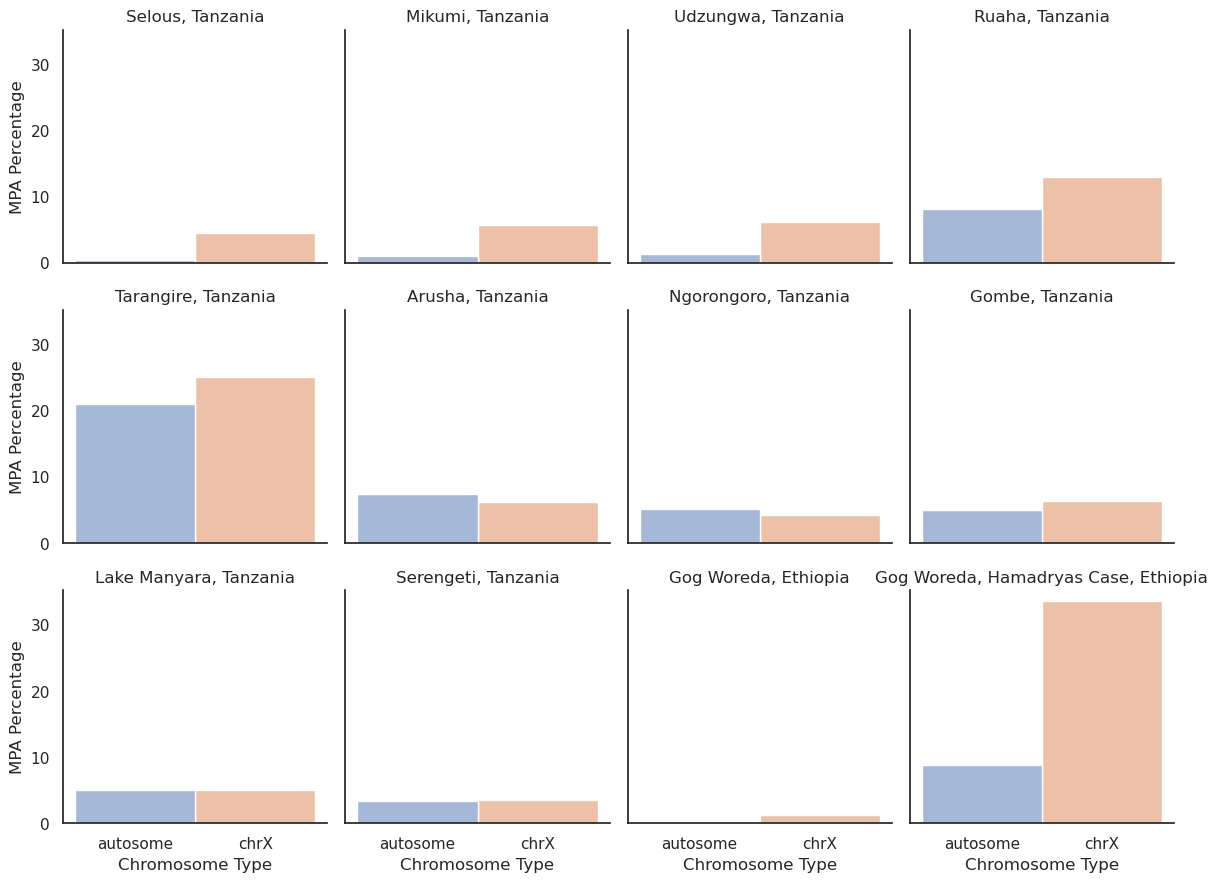

In [10]:
col_order = ['Selous, Tanzania', 'Mikumi, Tanzania', 'Udzungwa, Tanzania', 'Ruaha, Tanzania',
       'Tarangire, Tanzania', 'Arusha, Tanzania', 'Ngorongoro, Tanzania', 'Gombe, Tanzania', 
             'Lake Manyara, Tanzania', 'Serengeti, Tanzania', "Gog Woreda, Ethiopia", "Gog Woreda, Hamadryas Case, Ethiopia"]
g = sns.FacetGrid(data=total_df, col="Origin", col_wrap=4, col_order=col_order)
g.map_dataframe(sns.histplot, x="chrom_type", hue="chrom_type", weights="minor_parent_percentage")
g.set(xlabel="Chromosome Type", ylabel="MPA Percentage")
g.set_titles(col_template="{col_name}")

In [11]:
wide_df = total_df.loc[total_df.chrom_type == "autosome"].merge(total_df.loc[total_df.chrom_type == "chrX"], on="Origin")

In [16]:
wide_df = wide_df.sort_values(by=["north_percent_x"])
wide_df[["Origin", "minor_parent_percentage_x", "minor_parent_percentage_y"]]

,Origin,minor_parent_percentage_x,minor_parent_percentage_y
0,"Selous, Tanzania",0.361,4.52
9,"Mikumi, Tanzania",1.04,5.72
8,"Udzungwa, Tanzania",1.35,6.14
10,"Ruaha, Tanzania",8.04,12.9
6,"Gog Woreda, Hamadryas Case, Ethiopia",8.72,33.5
7,"Tarangire, Tanzania",20.9,25
5,"Arusha, Tanzania",7.31,6.2
4,"Ngorongoro, Tanzania",5.18,4.2
3,"Gombe, Tanzania",4.98,6.31
2,"Lake Manyara, Tanzania",4.98,5.05


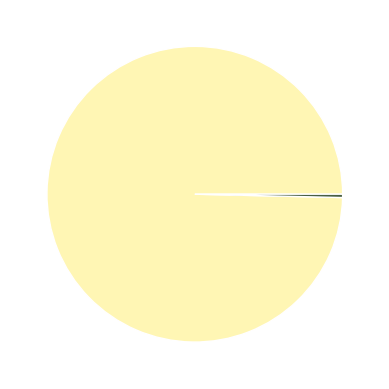

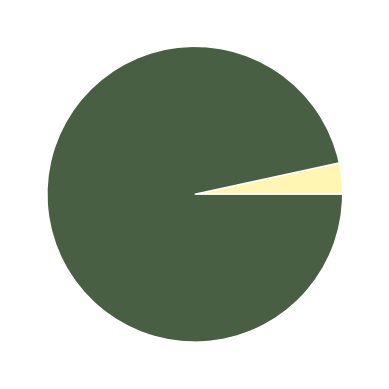

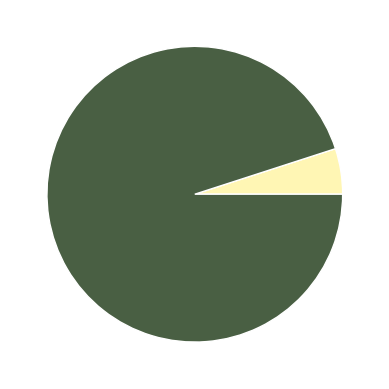

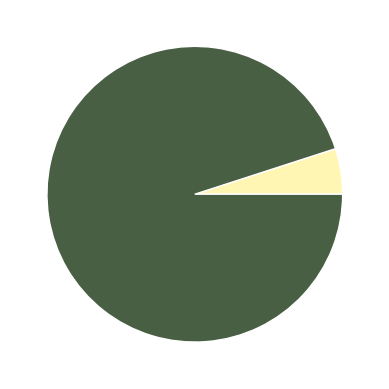

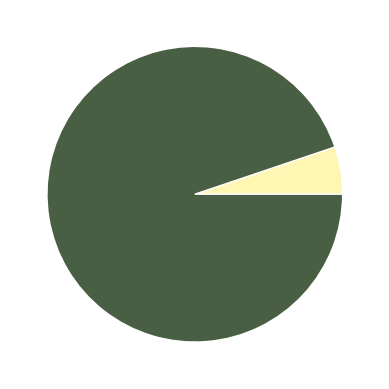

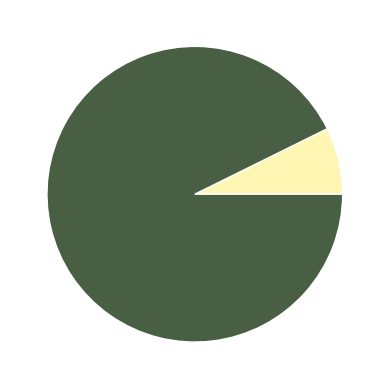

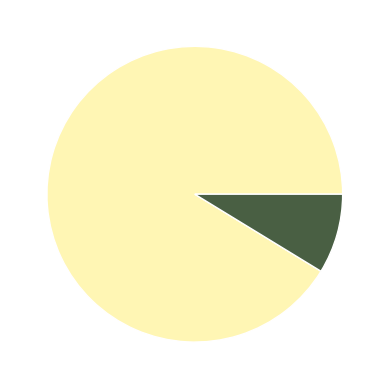

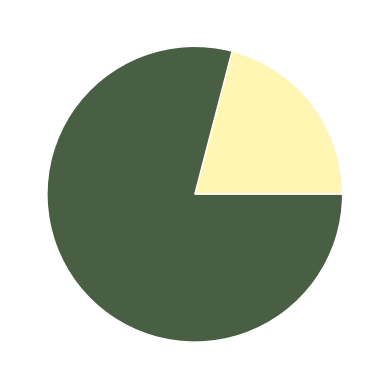

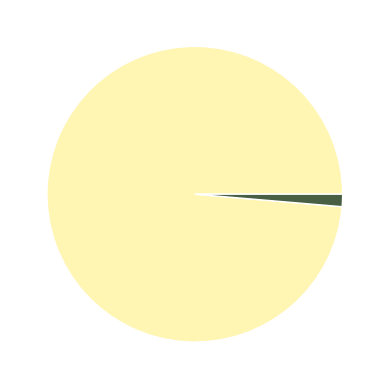

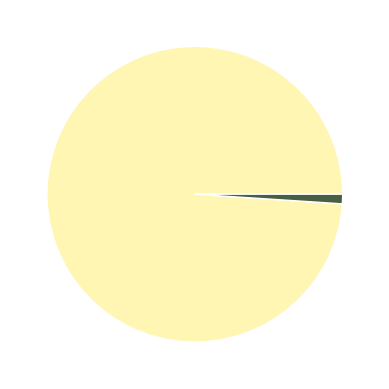

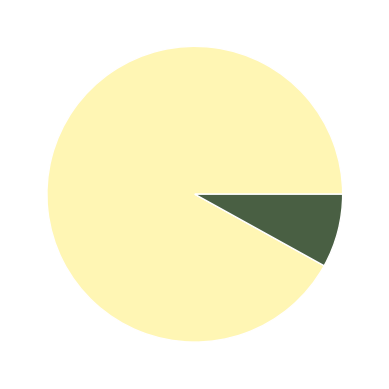

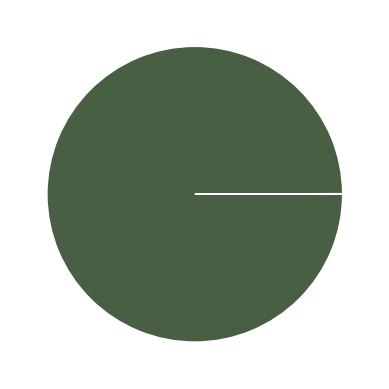

<Figure size 640x480 with 0 Axes>

In [107]:
data = [10, 90] 
keys = ['Southern Ancestry', 'Northern Ancestry'] 
  # Colors
hamadryas_north = '#91a89e'
olive_north = '#495F43'
yellow_south = '#FFF6B4'
# plotting data on chart 
for o in total_df.Origin.unique():
    np=total_df.loc[(total_df.Origin == o) & (total_df.chrom_type == "autosome")].north_percent.iloc[0]
    plt.pie([100-np, np], colors=[yellow_south, olive_north])
    #plt.title(o)
    plt.savefig('../figures/{}_pie.png'.format(o), format='png', transparent=True)
    plt.show()
    plt.figure()

In [108]:
df_l = []
for o in origins_interest:
    print(o)
    o_IDs = meta_data_samples_sci.loc[meta_data_samples_sci.Origin == o].PGDP_ID
    o_df = mean_window_df_tanz.loc[(mean_window_df_tanz.individual.isin(o_IDs)) &
                              (~mean_window_df_tanz.chrom.isin(["chrX", "female_chrX"]))]
    g_df = o_df.groupby(["chrom", "individual"])[["north_sum"]].mean().reset_index()
    if o == "Gog Woreda, Gambella region, Ethiopia":
        g_df["Origin"] = "Gog Woreda, Ethiopia"
    else:
        g_df["Origin"] = o
    df_l.append(g_df)
    o_df = mean_window_df_tanz.loc[(mean_window_df_tanz.individual.isin(o_IDs)) &
                              (mean_window_df_tanz.chrom.isin(["chrX"]))]
    male_IDs = meta_data_samples_sci.loc[meta_data_samples_sci.Sex == "M"].PGDP_ID
    o_df = o_df.loc[~(o_df.individual.isin(male_IDs) & (o_df.haplotype == 1))]
    g_df = o_df.groupby(["chrom", "individual"])[["north_sum"]].mean().reset_index()
    if o == "Gog Woreda, Gambella region, Ethiopia":
        g_df["Origin"] = "Gog Woreda, Ethiopia"
    else:
        g_df["Origin"] = o
    df_l.append(g_df)
for o in ['Gog Woreda, Gambella region, Ethiopia']:
    print(o)
    o_IDs = meta_data_samples_sci.loc[meta_data_samples_sci.Origin == o].PGDP_ID
    o_df = mean_window_df_eth.loc[(mean_window_df_eth.individual.isin(o_IDs)) &
                              (~mean_window_df_eth.chrom.isin(["chrX", "female_chrX"]))]
    g_df = o_df.groupby(["chrom", "individual"])[["north_sum"]].mean().reset_index()
    g_df["Origin"] = o
    df_l.append(g_df)
    o_df = mean_window_df_eth.loc[(mean_window_df_eth.individual.isin(o_IDs)) &
                              (mean_window_df_eth.chrom.isin(["chrX"]))]
    male_IDs = meta_data_samples_sci.loc[meta_data_samples_sci.Sex == "M"].PGDP_ID
    o_df = o_df.loc[~(o_df.individual.isin(male_IDs) & (o_df.haplotype == 1))]
    g_df = o_df.groupby(["chrom", "individual"])[["north_sum"]].mean().reset_index()
    g_df["Origin"] = o
    df_l.append(g_df)

Arusha, Tanzania
Gombe, Tanzania
Lake Manyara, Tanzania
Mikumi, Tanzania
Ngorongoro, Tanzania
Ruaha, Tanzania
Selous, Tanzania
Serengeti, Tanzania
Tarangire, Tanzania
Udzungwa, Tanzania
Gog Woreda, Gambella region, Ethiopia
Gog Woreda, Gambella region, Ethiopia


In [111]:
c_df = pd.concat(df_l)
c_df["chrom_type"] = ["autosome" if x != "chrX" else "chrX" for x in c_df.chrom]
c_df["North Percentage"] = c_df.north_sum/1000
c_df["Species"] = c_df.Origin.map(dict(zip(meta_data_samples_sci.Origin, meta_data_samples_sci.Species)))
c_df["minor_parent_percentage"] = [x if y == ("cynocephalus") or z == "Gog Woreda, Gambella region, Ethiopia"
                                             else 100-x for x, y, z in zip(c_df["North Percentage"],
                                                                         c_df["Species"],
                                                                        c_df["Origin"])]

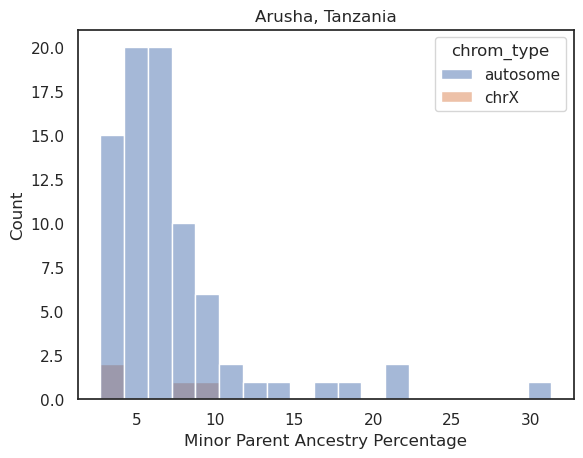

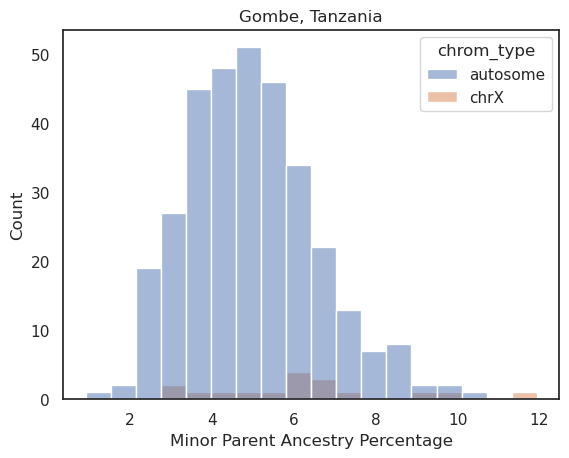

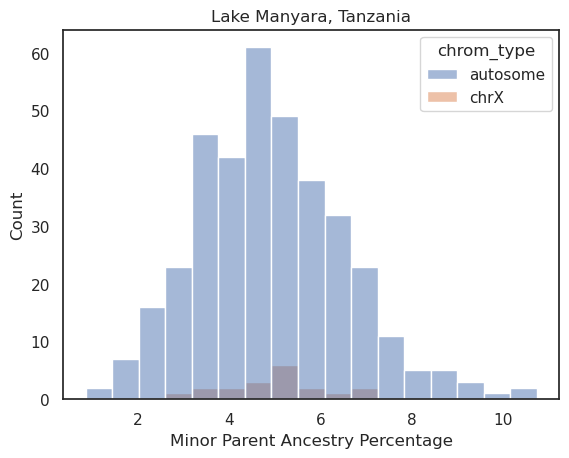

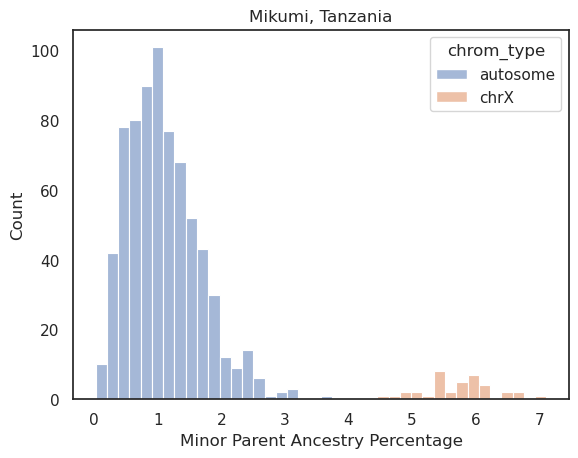

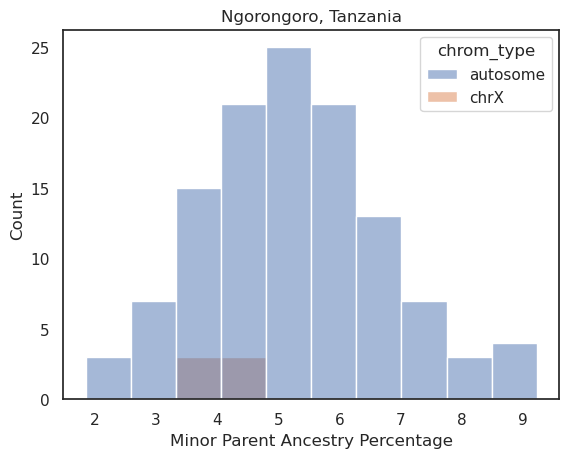

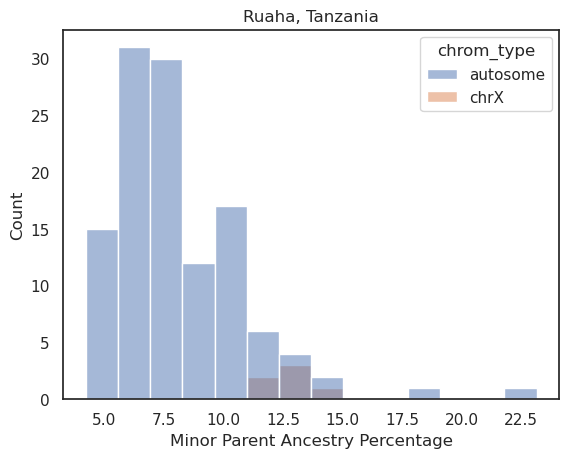

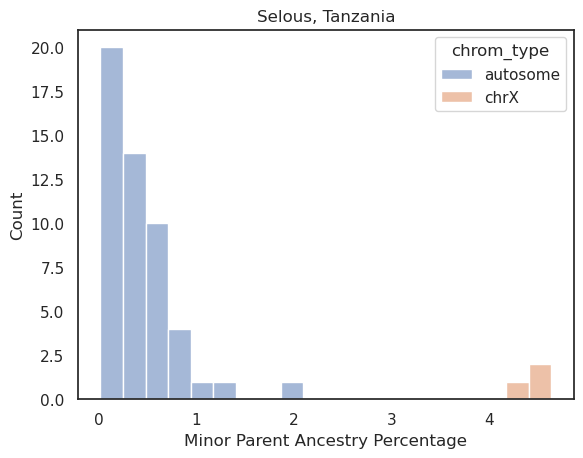

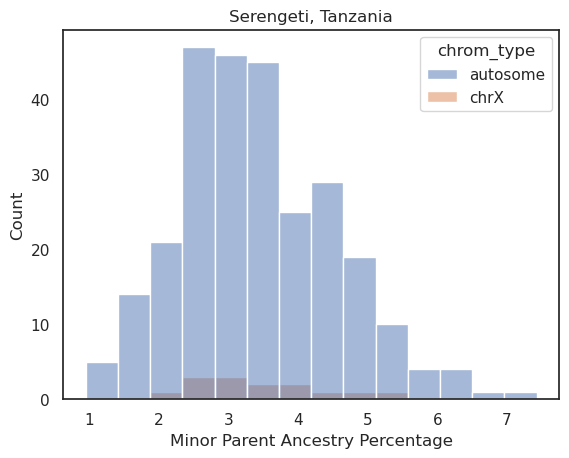

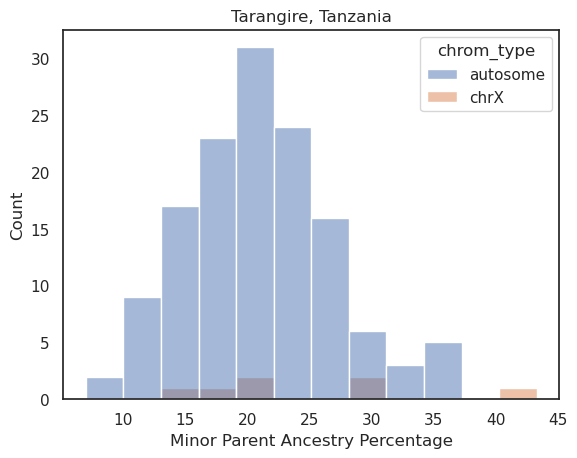

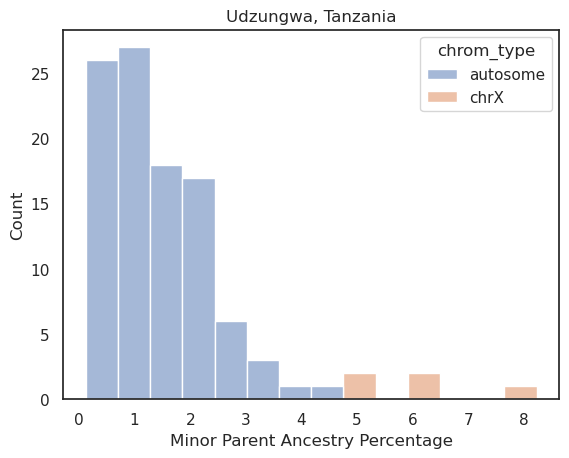

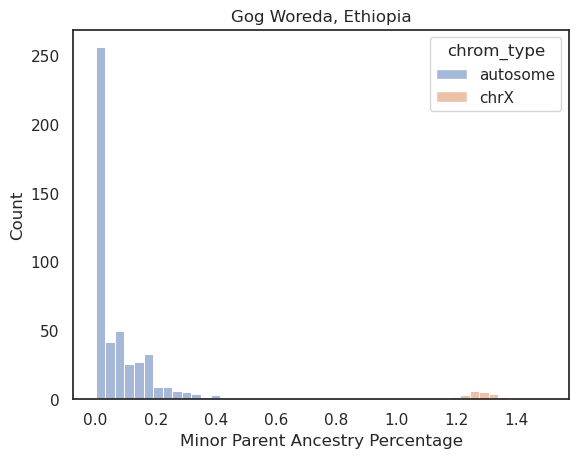

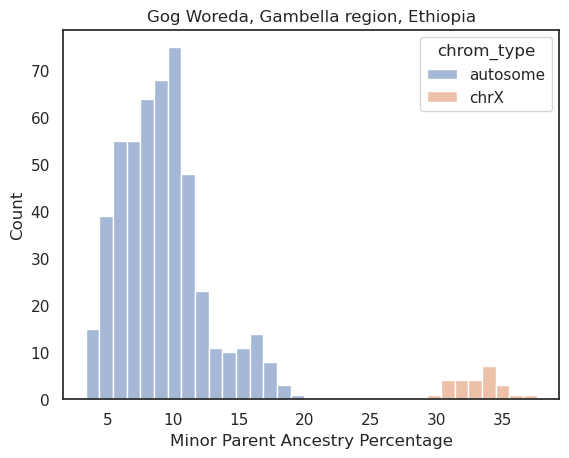

<Figure size 640x480 with 0 Axes>

In [112]:
for o in c_df.Origin.unique():
    g = sns.histplot(data=c_df.loc[c_df.Origin == o], x="minor_parent_percentage", hue="chrom_type")
    g.set_title(o)
    g.set(xlabel="Minor Parent Ancestry Percentage")
    plt.figure()

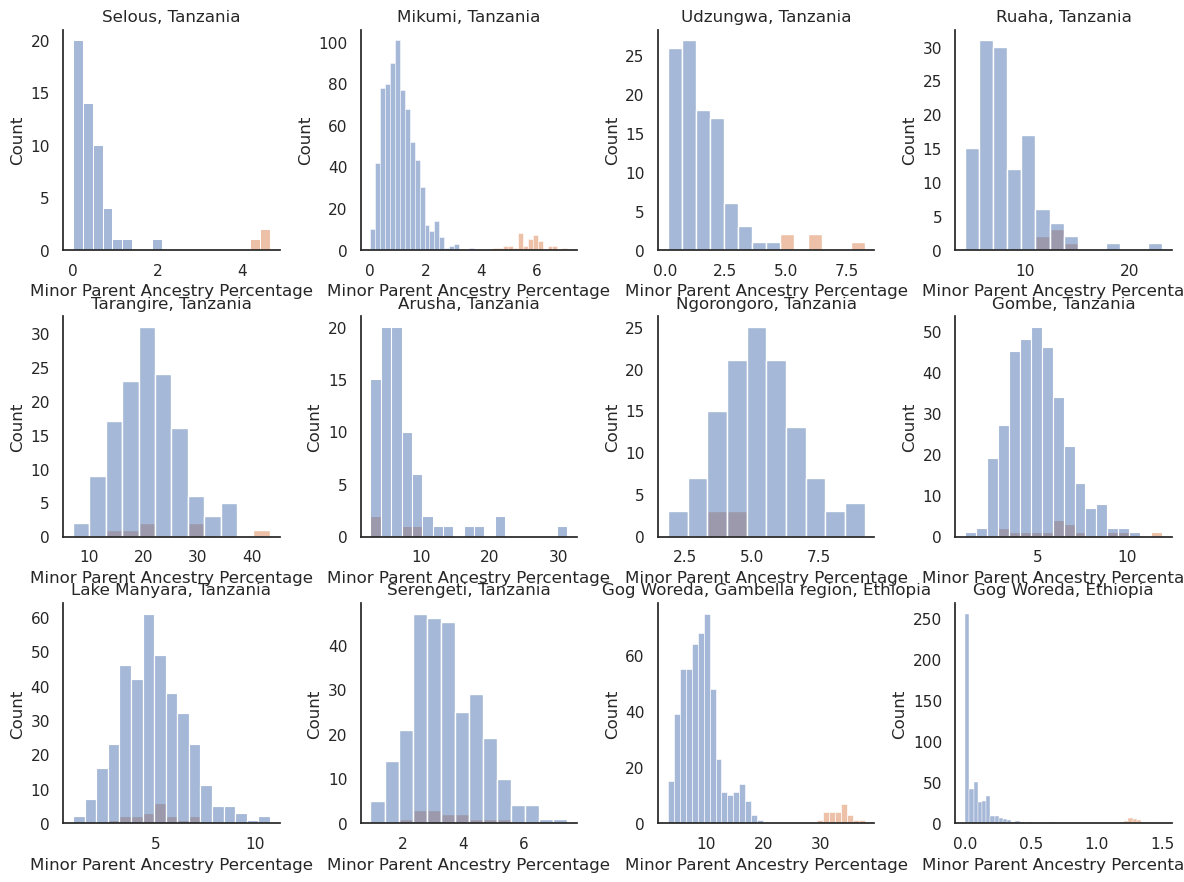

In [113]:
col_order = ['Selous, Tanzania', 'Mikumi, Tanzania', 'Udzungwa, Tanzania', 'Ruaha, Tanzania',
       'Tarangire, Tanzania', 'Arusha, Tanzania', 'Ngorongoro, Tanzania', 'Gombe, Tanzania', 
             'Lake Manyara, Tanzania', 'Serengeti, Tanzania', 'Gog Woreda, Gambella region, Ethiopia', 
            'Gog Woreda, Ethiopia']
g = sns.FacetGrid(data=c_df, col="Origin", col_wrap=4, col_order=col_order, sharex=False, sharey=False)
g.map_dataframe(sns.histplot, hue="chrom_type", x="minor_parent_percentage")
g.set(xlabel="Minor Parent Ancestry Percentage")
g.set_titles(col_template="{col_name}")

In [114]:
from scipy.stats import mannwhitneyu
o_l, aut_l, chrx_l, p_l = [], [], [], []
for o in col_order:
    d=c_df.loc[c_df.Origin == o]
    if len(d) > 1:
        U1, pnorm = mannwhitneyu(d.loc[d.chrom_type != "chrX"].minor_parent_percentage,
                                d.loc[d.chrom_type == "chrX"].minor_parent_percentage, method="exact")
        print(o, pnorm, len(d.loc[d.chrom_type == "chrX"].minor_parent_percentage))
        print("chrX diff is", (d.loc[d.chrom_type != "chrX"].minor_parent_percentage.mean()-d.loc[d.chrom_type == "chrX"].minor_parent_percentage.mean()))
        o_l.append(o), p_l.append(pnorm)
        aut_l.append((d.loc[d.chrom_type != "chrX"].minor_parent_percentage.mean())), chrx_l.append(d.loc[d.chrom_type == "chrX"].minor_parent_percentage.mean())

Selous, Tanzania 8.063215610385422e-05 3
chrX diff is -4.108812958244846
Mikumi, Tanzania 1.0569421406433147e-64 38
chrX diff is -4.632082804679165
Udzungwa, Tanzania 2.1747990376949217e-08 5
chrX diff is -4.751042668648019
Ruaha, Tanzania 1.959568078926787e-05 6
chrX diff is -4.744450086332295
Tarangire, Tanzania 0.36447489594734805 7
chrX diff is -3.95773915086696
Arusha, Tanzania 0.6778477958809039 4
chrX diff is 0.9896090892238032
Ngorongoro, Tanzania 0.026801313385602835 6
chrX diff is 1.0789412261876068
Gombe, Tanzania 0.010383884682179847 17
chrX diff is -1.3141024476853325
Lake Manyara, Tanzania 0.5335724376069119 19
chrX diff is -0.12313327957796716
Serengeti, Tanzania 0.7558198627292966 14
chrX diff is -0.07049443292825242
Gog Woreda, Gambella region, Ethiopia 5.49306071357232e-43 25
chrX diff is -23.99211602332605
Gog Woreda, Ethiopia 1.915868681540407e-42 25
chrX diff is -1.2312404030846578


In [115]:
mw_df = pd.DataFrame({"Origin": o_l, "Mean Autosome MPA": aut_l, "Mean ChrX MPA": chrx_l, "Mann-Whitney P-value": p_l})
mw_df["Autosome - chrX"] =  mw_df["Mean Autosome MPA"]- mw_df["Mean ChrX MPA"]
mw_df

,Origin,Mean Autosome MPA,Mean ChrX MPA,Mann-Whitney P-value,Autosome - chrX
0,"Selous, Tanzania",0.414,4.52,8.06e-05,-4.11
1,"Mikumi, Tanzania",1.09,5.72,1.06e-64,-4.63
2,"Udzungwa, Tanzania",1.38,6.14,2.17e-08,-4.75
3,"Ruaha, Tanzania",8.17,12.9,1.96e-05,-4.74
4,"Tarangire, Tanzania",21,25,0.364,-3.96
5,"Arusha, Tanzania",7.19,6.2,0.678,0.99
6,"Ngorongoro, Tanzania",5.28,4.2,0.0268,1.08
7,"Gombe, Tanzania",4.99,6.31,0.0104,-1.31
8,"Lake Manyara, Tanzania",4.93,5.05,0.534,-0.123
9,"Serengeti, Tanzania",3.41,3.48,0.756,-0.0705


In [18]:
window_size = 100000
chroms = ["{}".format(x) for x in (range(1, 21))] + ["X", "hapX"]

pval_df_l = []
for c in ["hapX"]:
    print(c)
    pos_list, pval_list = [], []
    relate_sele = pd.read_csv("../results/Tanzania_Olive_relate/chrom{}_selection.sele".format(c), sep=" ")
    relate_sele["-log10 P-value"] = -relate_sele["when_mutation_has_freq2"]
    for i in range(0, relate_sele.pos.iloc[-1], window_size):
        sub_df = relate_sele.loc[(relate_sele.pos >= i) & (relate_sele.pos < i+window_size)]
        if len(sub_df) > 1:
            sorted_df = sub_df.sort_values(["-log10 P-value"], ascending = False)
            pos_list.append(sorted_df.pos.iloc[0]), pval_list.append(sorted_df["-log10 P-value"].iloc[0])
        else:
            pos_list.append(np.NaN), pval_list.append(0)
    pval_df = pd.DataFrame({"chrom": "chr"+c, "start": list(range(0, relate_sele.pos.iloc[-1], window_size)),
                              "peak_pos": pos_list, "pval": pval_list})
    pval_df_l.append(pval_df)
        
sel_df_hapx = pd.concat(pval_df_l)
sel_df_hapx.to_csv("../steps/rfmix_stats_df/Tanzania_Olive_hapX_pval_peaks.txt", index=False)

hapX


In [19]:
mean_north_tanz = mean_window_df_tanz_olive.groupby(["chrom", "start"])[["north_sum"]].mean().reset_index()

In [20]:
sel_df = pd.read_csv("../steps/rfmix_stats_df/Tanzania_Olive_pval_peaks.txt")
c_r_g_df = pd.read_csv("../steps/rfmix_stats_df/call_recomb_genes.txt")
sel_df = sel_df.merge(c_r_g_df, on=["chrom", "start"])
sel_df = sel_df.merge(mean_north_tanz, on=["chrom", "start"])

In [21]:
sel_df.chrom.unique()

array(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8',
       'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr20'], dtype=object)

In [22]:
sel_df

,chrom,start,peak_pos,pval,callable_frac,end,cM,end_cM,average_cM_window,genes,genic,north_sum
0,chr1,0,87855.0,3.46627,0.04690,100000,0.000000,0.360307,3.603071e-06,"['RNF223', 'C1H1orf159', 'C1H1orf159', 'C1H1or...",True,98822.746269
1,chr1,100000,195402.0,2.99136,0.64769,200000,0.360307,0.476530,1.162234e-06,"['TTLL10', 'TTLL10', 'TTLL10', 'TTLL10', 'TTLL...",True,99243.305970
2,chr1,200000,226513.0,3.03398,0.95965,300000,0.476530,0.547039,7.050811e-07,"['B3GALT6', 'C1QTNF12', 'UBE2J2', 'UBE2J2', 'U...",True,98507.462687
3,chr1,300000,369905.0,2.53134,0.94918,400000,0.547039,0.626412,7.937342e-07,"['DVL1', 'DVL1', 'DVL1', 'MXRA8', 'MXRA8', 'MX...",True,98507.462687
4,chr1,400000,461825.0,2.79970,0.78703,500000,0.626412,1.366901,7.404885e-06,"['VWA1', 'TMEM240', 'SSU72']",True,98016.619403
...,...,...,...,...,...,...,...,...,...,...,...,...
23234,chr20,71600000,71675641.0,2.99136,0.90938,71700000,75.889470,76.039495,1.500244e-06,"['CHMP1A', 'SPATA33', 'SPATA33', 'CDK10', 'CDK...",True,96832.425373
23235,chr20,71700000,71789506.0,3.98652,0.95799,71800000,76.039495,76.200273,1.607780e-06,"['FANCA', 'FANCA', 'FANCA', 'FANCA', 'FANCA', ...",True,96867.253731
23236,chr20,71800000,71850144.0,5.53754,0.90171,71900000,76.200273,76.341596,1.413238e-06,"['SPIRE2', 'SPIRE2', 'SPIRE2', 'TCF25', 'TCF25...",True,95729.037313
23237,chr20,71900000,71945040.0,5.22578,0.84299,72000000,76.341596,76.492347,1.507505e-06,"['DEF8', 'DEF8', 'DEF8', 'DEF8', 'DEF8', 'DEF8...",True,95438.126866


In [23]:
sel_df.sort_values(by="pval")

,chrom,start,peak_pos,pval,callable_frac,end,cM,end_cM,average_cM_window,genes,genic,north_sum
22227,chr19,22300000,NaN,0.00000,0.94088,22400000,45.098346,45.326467,2.281201e-06,[],False,81645.014925
22223,chr19,21900000,NaN,0.00000,0.95768,22000000,44.349612,44.384741,3.512902e-07,[],False,46701.813433
22222,chr19,21800000,NaN,0.00000,0.95280,21900000,43.379029,44.349612,9.705827e-06,[],False,61765.186567
22221,chr19,21700000,NaN,0.00000,0.96096,21800000,43.065682,43.379029,3.133466e-06,[],False,86178.208955
22220,chr19,21600000,NaN,0.00000,0.93035,21700000,42.670993,43.065682,3.946891e-06,[],False,88631.149254
...,...,...,...,...,...,...,...,...,...,...,...,...
22387,chr19,38300000,38331675.0,9.14932,0.91480,38400000,68.644339,68.744470,1.001311e-06,"['CEACAM19', 'CEACAM16', 'BCL3']",True,94029.544776
2647,chr2,121000000,121007104.0,9.22094,0.96173,121100000,80.604824,80.673932,6.910811e-07,[],False,92517.858209
3451,chr3,57700000,57757861.0,9.29162,0.93699,57800000,69.057360,69.176642,1.192827e-06,[],False,96206.201493
10119,chr8,6000000,6019807.0,9.29162,0.78886,6100000,11.245482,11.367648,1.221660e-06,[],False,96671.626866


In [24]:
sel_df_aut = sel_df.loc[(sel_df.chrom.isin(["chr{}".format(x) for x in (range(1, 21))]))]

In [25]:
sel_df_aut.loc[sel_df_aut.pval >= 7.5].north_sum

277      93820.253731
296      94029.850746
638      95829.276119
807      97160.141791
941      94029.828358
             ...     
23088    94162.492537
23170    94199.328358
23174    95506.283582
23189    91744.507463
23214    94235.126866
Name: north_sum, Length: 151, dtype: float64

In [26]:
from scipy import stats
from scipy.stats import ranksums
from scipy.stats import mannwhitneyu
ranksums(sel_df_aut.loc[sel_df_aut.pval >= 7.5].north_sum, sel_df_aut.loc[sel_df_aut.pval < 7.5].north_sum)
# Means are significiantly different, with the sweeps being slightly more pure.

RanksumsResult(statistic=2.118908249412037, pvalue=0.0340982216515582)

In [57]:
stats.ttest_ind(sel_df_aut.loc[sel_df_aut.pval >= 7.5].north_sum,
                sel_df_aut.loc[sel_df_aut.pval < 7.5].north_sum,
               equal_var=False)


Ttest_indResult(statistic=8.046432102018255, pvalue=1.680753680586383e-13)

In [27]:
100000-sel_df_aut.loc[sel_df_aut.pval >= 7.5].north_sum.mean(), 100000-sel_df_aut.loc[sel_df_aut.pval < 7.5].north_sum.mean()

(5086.023302643967, 6555.073008016319)

In [28]:
(100000-sel_df_aut.loc[sel_df_aut.pval >= 7.5].north_sum.mean())/(100000-sel_df_aut.loc[sel_df_aut.pval < 7.5].north_sum.mean())

0.7758911756473461

In [29]:
res = stats.fligner(sel_df_aut.loc[sel_df_aut.pval >= 7.5].north_sum, sel_df_aut.loc[sel_df_aut.pval < 7.5].north_sum)
res.pvalue

2.405563078105072e-13

In [30]:
sel_df_aut["P-value Significance"] = ["Significant -10log P-value" if x >= 7.5 else "Not significant" for x in sel_df_aut.pval]
sel_df_aut["Minor Parent Ancestry Percentage"] = 1-(sel_df_aut.north_sum/100000)

[(0.0, 0.25), Text(0.5, 1.0, 'Autosomes')]

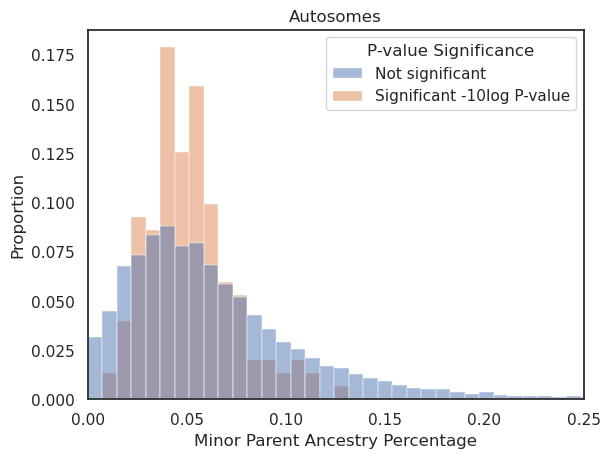

In [33]:
g = sns.histplot(sel_df_aut, x="Minor Parent Ancestry Percentage", hue="P-value Significance", stat="proportion", common_norm = False, bins=100)
g.set(xlim=(0, 0.25), title="Autosomes")

<Axes: xlabel='north_sum', ylabel='Count'>

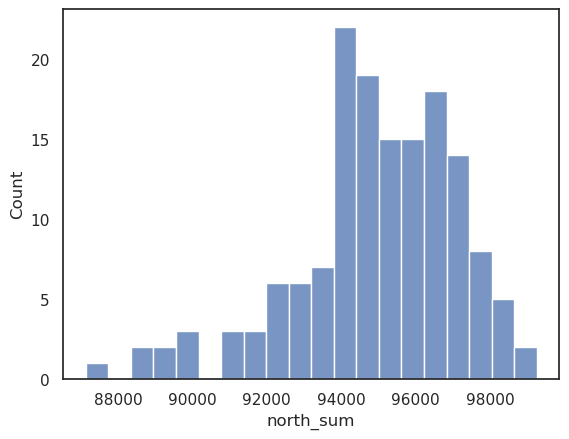

In [177]:
sns.histplot(sel_df_aut.loc[sel_df_aut.pval > 7.5].north_sum, bins=20)

In [178]:
sel_df_aut.loc[sel_df_aut.pval >= 7.5].north_sum.std(), sel_df_aut.loc[sel_df_aut.pval < 7.5].north_sum.std()

(2198.052132753319, 5554.1494871981995)

ChrX check

In [34]:
sel_df_hapx = pd.read_csv("../steps/rfmix_stats_df/Tanzania_Olive_hapX_pval_peaks.txt")

In [35]:
sel_df_hapx["chrom"] = "chrX"

In [36]:
sel_df_hapx

,chrom,start,peak_pos,pval
0,chrX,0,NaN,0.00000
1,chrX,100000,NaN,0.00000
2,chrX,200000,NaN,0.00000
3,chrX,300000,NaN,0.00000
4,chrX,400000,NaN,0.00000
...,...,...,...,...
1432,chrX,143200000,143268237.0,1.56313
1433,chrX,143300000,143393812.0,1.73927
1434,chrX,143400000,143430918.0,1.91986
1435,chrX,143500000,143502164.0,1.56313


In [37]:
c_r_g_df = pd.read_csv("../steps/rfmix_stats_df/call_recomb_genes.txt")
sel_df_hapx = sel_df_hapx.merge(c_r_g_df, on=["chrom", "start"])
mean_north_tanz_x = mean_north_tanz.loc[mean_north_tanz.chrom == "all_chrX"]
mean_north_tanz_x["chrom"] = "chrX"
sel_df_hapx = sel_df_hapx.merge(mean_north_tanz_x, on=["chrom", "start"])

/scratch/40238067/ipykernel_3123267/615393061.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_north_tanz_x["chrom"] = "chrX"


In [38]:
sel_df_hapx

,chrom,start,peak_pos,pval,callable_frac,end,cM,end_cM,average_cM_window,genes,genic,north_sum
0,chrX,0,NaN,0.00000,0.04690,100000,0.000000,0.982930,9.829296e-06,"['CD99', 'CD99', 'CD99', 'CD99', 'CD99', 'XG',...",True,0.000000
1,chrX,100000,NaN,0.00000,0.64769,200000,0.982930,1.322269,3.393394e-06,"['XG', 'XG', 'XG', 'XG', 'XG', 'XG', 'XG', 'XG...",True,0.000000
2,chrX,200000,NaN,0.00000,0.95965,300000,1.322269,1.504651,1.823823e-06,"['GYG2', 'GYG2', 'GYG2', 'GYG2', 'GYG2', 'GYG2...",True,0.000000
3,chrX,300000,NaN,0.00000,0.94918,400000,1.504651,1.703484,1.988331e-06,"['ARSE', 'ARSE', 'ARSE', 'ARSE', 'ARSE', 'ARSE...",True,0.000000
4,chrX,400000,NaN,0.00000,0.78703,500000,1.703484,1.748264,4.477935e-07,"['ARSF', 'ARSF', 'ARSF', 'ARSF']",True,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1432,chrX,143200000,143268237.0,1.56313,0.66998,143300000,126.757529,126.783155,2.562611e-07,"['TMLHE', 'TMLHE', 'TMLHE', 'TMLHE', 'TMLHE']",True,96268.656716
1433,chrX,143300000,143393812.0,1.73927,0.90454,143400000,126.783155,126.816893,3.373798e-07,"['TMLHE', 'TMLHE', 'TMLHE', 'TMLHE']",True,96268.656716
1434,chrX,143400000,143430918.0,1.91986,0.78855,143500000,126.816893,126.844878,2.798504e-07,['SPRY3'],True,96268.656716
1435,chrX,143500000,143502164.0,1.56313,0.83590,143600000,126.844878,126.920225,7.534706e-07,['VAMP7'],True,96268.656716


In [59]:
stats.ttest_ind(sel_df_hapx.loc[sel_df_hapx.pval >= 6].north_sum,
                sel_df_hapx.loc[sel_df_hapx.pval < 6].north_sum,
               equal_var=False)

Ttest_indResult(statistic=0.6091565984282742, pvalue=0.5519971842540424)

In [51]:
100000-sel_df_hapx.loc[sel_df_hapx.pval >= 6].north_sum.mean(), 100000-sel_df_hapx.loc[sel_df_hapx.pval < 6].north_sum.mean()

(7179.470149253728, 7809.507122283321)

In [53]:
sel_df_hapx["P-value Significance"] = ["Significant over -10log P-value" if x >= 6 else "Not significant" for x in sel_df_hapx.pval]
sel_df_hapx["Minor Parent Ancestry Percentage"] = 1-(sel_df_hapx.north_sum/100000)

[(0.0, 0.25), Text(0.5, 1.0, 'Chromosome X')]

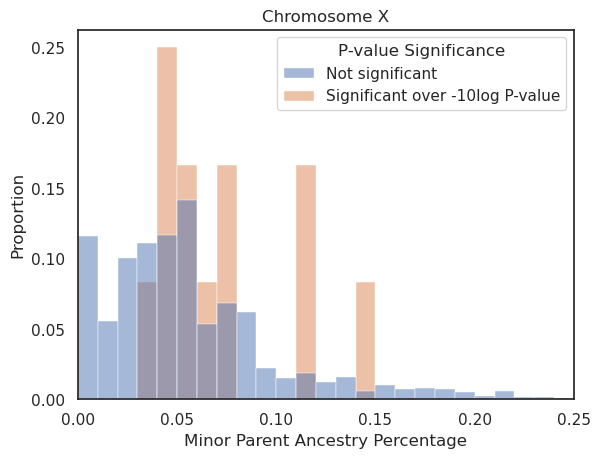

In [54]:
g = sns.histplot(sel_df_hapx, x="Minor Parent Ancestry Percentage", hue="P-value Significance", stat="proportion", common_norm = False, bins=100)
g.set(xlim=(0, 0.25), title="Chromosome X")

focus_pop_tag = "Anubis, Tanzania"
donor_1 = "Anubis, Ethiopia"
donor_2 = "Cynocephalus, Central Tanzania"
window_size = 100000
all_chroms = ["chr{}".format(x) for x in (range(1, 21))]+["all_chrX", "chrX", "dipmale_chrX"]

def fst(ac1, ac2):
    num, den = allel.hudson_fst(ac1, ac2, fill=0)
    return np.sum(num) / np.sum(den)

c_df_l = []
for c in all_chroms:
    print(c)
    zarr_dir = "/home/eriks/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/" + c
    #Opening the zarr data
    callset = zarr.open_group(zarr_dir, mode="r")
    gt = allel.GenotypeArray(callset["calldata/GT"])
    pos = callset["variants/POS"][:]
    # Loading in the IDs and gt
    if c == "all_chrX":
        metadata = hap_meta_data_samples
    elif c == "chrX":
        metadata = meta_data_samples_f
    elif c == "dipmale_chrX":
        metadata = meta_data_samples_dip
    else:
        metadata = meta_data_samples
    focus_pop_IDs = metadata.loc[metadata.C_origin == focus_pop_tag].PGDP_ID
    focus_pop_gt = gt.take(metadata.loc[metadata.C_origin == focus_pop_tag].callset_index,
                       axis=1)
    donor_1_pop = metadata.loc[metadata.C_origin == donor_1].callset_index
    donor_1_gt = gt.take(donor_1_pop, axis=1)
    donor_2_pop = metadata.loc[metadata.C_origin == donor_2].callset_index
    donor_2_gt = gt.take(donor_2_pop, axis=1)
    df_l = []
    for ind in focus_pop_IDs:
        if ind[-1:] == "b":
            continue
        elif ind[-1:] == "a":
            focus_ind_gt = focus_pop_gt = gt.take(metadata.loc[metadata.PGDP_ID.isin([ind, ind[:-1]+"b"])].callset_index,
                           axis=1)
            rest_pop_gt = focus_pop_gt = gt.take(metadata.loc[(~metadata.PGDP_ID.isin([ind, ind[:-1]+"b"])) &
                                                                                   metadata.PGDP_ID.isin(focus_pop_IDs)].callset_index,
                           axis=1)
            ID = ind[:-2]
        else:
            focus_ind_gt = focus_pop_gt = gt.take(metadata.loc[metadata.PGDP_ID.isin([ind])].callset_index,
                           axis=1)
            rest_pop_gt = focus_pop_gt = gt.take(metadata.loc[(~metadata.PGDP_ID.isin([ind])) &
                                                                               metadata.PGDP_ID.isin(focus_pop_IDs)].callset_index,
                           axis=1)
            ID = ind
        if ID[0] != "P" and ID[0] != "S":
            ID = "Sci_" + ID
        dxy_focus, windows, n_bases, counts =  allel.windowed_divergence(pos, focus_ind_gt.count_alleles(),
                          rest_pop_gt.count_alleles(), size=window_size, start=0)
        dxy_donor_1, windows, n_bases, counts =  allel.windowed_divergence(pos, focus_ind_gt.count_alleles(),
                          donor_1_gt.count_alleles(), size=window_size, start=0)
        dxy_donor_2, windows, n_bases, counts =  allel.windowed_divergence(pos, focus_ind_gt.count_alleles(),
                          donor_2_gt.count_alleles(), size=window_size, start=0)
        df_l.append(pd.DataFrame({"chrom": c, "individual": ID, "start": windows[:,0], "focus_div": dxy_focus,
                  "donor_1_div": dxy_donor_1, "donor_2_div": dxy_donor_2}))
    focus_df = pd.concat(df_l)
    if c == "chrX":
        rf_c = "female_chrX"
    elif c == "dipmale_chrX":
        rf_c = "all_chrX"
    else:
        rf_c = c
    print(c, rf_c)
    c_rfmix = mean_window_df_tanz_olive.loc[mean_window_df_tanz_olive.chrom == rf_c]
    c_rfmix["chrom"] = c
    per_ind_df = c_rfmix.merge(focus_df, on=["chrom", "individual", "start"])
    pi, windows, n_bases, counts_pi = allel.windowed_diversity(pos,
                                                        ac=focus_pop_gt.count_alleles(), size=window_size, start=0)
    fst1, windows, counts = allel.windowed_statistic(pos, (focus_pop_gt.count_alleles(),
                                                      donor_1_gt.count_alleles()), fst, size=window_size, start=0)
    fst2, windows, counts = allel.windowed_statistic(pos, (focus_pop_gt.count_alleles(),
                                                      donor_2_gt.count_alleles()), fst, size=window_size, start=0)
    theta_hat_w, windows, n_bases, counts = allel.windowed_watterson_theta(pos,
                                                        ac=focus_pop_gt.count_alleles(), size=window_size, start=0)

    group_stats = pd.DataFrame({"chrom": c, "start": windows[:,0], "pi": pi, "count": counts_pi,
                            "fst_1": fst1, "fst_2": fst2, "w_theta": theta_hat_w})
    ind_group_df = per_ind_df.merge(group_stats, on=["chrom", "start"])
    ind_group_df.to_csv("../steps/rfmix_stats_df/{}_stats_tanz_anubis.txt".format(c), index=False)